[Video Youtube](https://www.youtube.com/watch?v=mvUTK76Ag08)

In [1]:
import pandas as pd

https://archive.ics.uci.edu/ml/datasets/Abalone

In [2]:
columns = ['Sex', 'Length', 'Diameter', 'Height', 'Whole_Weight', 
           'Shucked_Weight', 'Viscera_Weight', 'Shell_Weight', 'Rings']
df = pd.read_csv('abalone.data', names=columns)

In [3]:
df.head()

,Sex,Length,Diameter,Height,Whole_Weight,Shucked_Weight,Viscera_Weight,Shell_Weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [4]:
label = 'Rings'
categorical = ['Sex']
numerical = ['Length', 'Diameter', 'Height', 'Whole_Weight', 
             'Shucked_Weight', 'Viscera_Weight', 'Shell_Weight']

In [5]:
(df[label] >= 10).sum(), (df[label] < 10).sum()

(2081, 2096)

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
X = df.drop(labels=label, axis=1)
y = (df[label] < 10)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y,
                                                    random_state=42)

A biblioteca sklearn.base possui ferramentas para criarmos nossos proprios transformadores e estimadores. Usaremos ela para criar um transformador que separa o nosso dataset apenas nas colunas que desejamos usar. Assim, podemos criar um dataframe apenas com dados categóricos e outra apenas com dados numéricos.

In [8]:
from sklearn.base import TransformerMixin

In [9]:
class DataframeSelector(TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        assert isinstance(X, pd.DataFrame)
        try:
            return pd.DataFrame(data=X[self.columns].values, columns=self.columns)
        except KeyError:
            cols_error = list(set(self.columns) - set(X.columns))
            raise KeyError("The DataFrame does not include the columns: %s" % cols_error)

Com essa separação, criaremos pipelines para tratar de cada tipo de dado separadamente

In [10]:
num_df = DataframeSelector(numerical)
cat_df = DataframeSelector(categorical)

Tratamos os dados faltantes de cada um dos dataframes, aplicando metodos de preenchimento diferentes

In [11]:
from sklearn.impute import SimpleImputer
num_imputer = SimpleImputer(strategy='mean')
cat_imputer = SimpleImputer(strategy='most_frequent')

Como os dados numéricos e categóricos estão separados, podemos aplicar a normalização em um dataframe, e a codificação dos dados categóricos em outro

In [12]:
from sklearn.preprocessing import StandardScaler
num_scaler = StandardScaler()

In [13]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder(sparse=False)

Com os transformadores criados, criamos as pipelines. Numa pipeline, os transformadores são aplicados na ordem passada, com cada um passando os dados transformados por si para o próximo.

In [14]:
from sklearn.pipeline import make_pipeline
num_pipeline = make_pipeline(num_df, num_imputer, num_scaler)
cat_pipeline = make_pipeline(cat_df, cat_imputer, cat_encoder)

Como dividimos o nosso dataset, precisamos uni-lo. Para isso podemos usar o make_union. Esse transformador aplica cada transformador que foi passado ao dataset, e ao fim realiza a união dos resultados de cada um.

In [15]:
from sklearn.pipeline import make_union
union = make_union(num_pipeline, cat_pipeline)

In [16]:
X_train_transformed = union.fit_transform(X_train)

In [17]:
X_train_transformed

array([[-0.61286535, -0.5794474 ,  0.1227306 , ...,  1.        ,
         0.        ,  0.        ],
       [ 1.21496297,  1.17862016,  0.94211414, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.59183968,  0.57585414,  0.1227306 , ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [-0.77903156, -0.67990841, -3.27185836, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.88263055,  0.67631514,  0.82505935, ...,  1.        ,
         0.        ,  0.        ],
       [-1.19444709, -1.08175242, -1.16487211, ...,  0.        ,
         1.        ,  0.        ]])

In [18]:
X_test_transformed = union.transform(X_test)

In [19]:
X_test_transformed

array([[ 0.34259036,  0.32470163,  0.82505935, ...,  0.        ,
         0.        ,  1.        ],
       [-1.02828088, -0.93106092, -0.93076252, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.841089  ,  0.62608464,  0.1227306 , ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [ 1.58883695,  1.78138619,  2.11266206, ...,  1.        ,
         0.        ,  0.        ],
       [-1.27753019, -1.33290493, -1.16487211, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.01025794,  0.22424063, -0.34548857, ...,  1.        ,
         0.        ,  0.        ]])

Temos por fim nossos dados de treino e test transformados. Podemos agora aplicar os dados a um estimador.

Para a predição utilizaremos o algoritimo GradientBoosting.
Para decidir os hyperparâmetros, utilizaremos o GridSearchCV e o RandomizedSearchCV

In [20]:
from sklearn.ensemble import GradientBoostingClassifier

No grid search, criamos uma lista de parâmetros possíveis para o modelo, e o grid testará todas as combinações possíveis, testando utilizando cross validation.

In [42]:
from sklearn.model_selection import GridSearchCV

params_grid = {
    'learning_rate': [0.05, 0.1],
    'max_depth': [5, 7],
    'n_estimators': [25, 50, 100],
    'max_features': [1, 3, 5],
    'min_samples_split': [2, 3, 4]
}

grid_clf = GridSearchCV(GradientBoostingClassifier(random_state=42), 
                        params_grid, cv=3, verbose=1)

In [43]:
%%time
grid_clf.fit(X_train_transformed, y_train)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


CPU times: user 59.8 s, sys: 11.7 ms, total: 59.8 s
Wall time: 59.9 s


[Parallel(n_jobs=1)]: Done 324 out of 324 | elapsed:   59.7s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no...
                                                  presort='auto',
  

In [44]:
grid_clf.best_params_

{'learning_rate': 0.1,
 'max_depth': 5,
 'max_features': 5,
 'min_samples_split': 2,
 'n_estimators': 50}

In [45]:
grid_clf.best_score_

0.7997605507333134

In [46]:
grid_clf.score(X_test_transformed, y_test)

0.7942583732057417

Para o RandomizedSearchCV, passamos distribuições, e os valores dos de hiperparametros são sorteados destas distribuições.

In [47]:
from scipy.stats import geom, expon, reciprocal, randint
import matplotlib.pyplot as plt

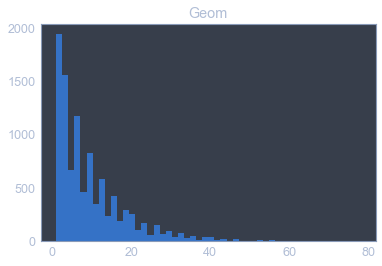

In [48]:
geom_distrib=geom(0.1).rvs(10000, random_state=42)
plt.title("Geom")
plt.hist(geom_distrib, bins=50)
plt.show()

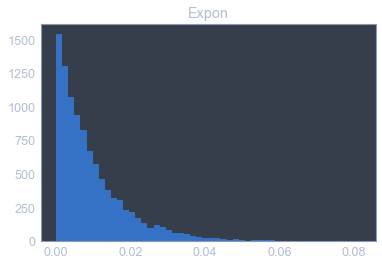

In [49]:
expon_distrib=expon(scale=0.01).rvs(10000, random_state=42)
plt.title("Expon")
plt.hist(expon_distrib, bins=50)
plt.show()

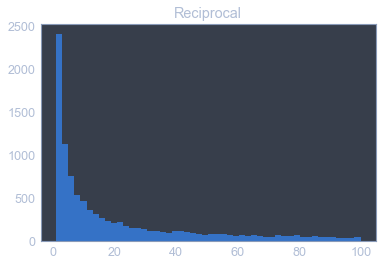

In [50]:
reciprocal_distrib=reciprocal(1, 100).rvs(10000, random_state=42)
plt.title("Reciprocal")
plt.hist(reciprocal_distrib, bins=50)
plt.show()

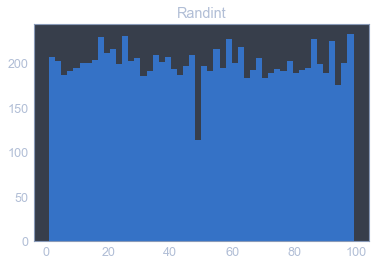

In [51]:
randint_distrib=randint(low=1, high=100).rvs(10000, random_state=42)
plt.title("Randint")
plt.hist(randint_distrib, bins=50)
plt.show()

No randomized search, criamos uma lista de parâmetros com as distribuições, e o randomized sorteará uma combinação de parametros, testando utilizando cross validation.

In [54]:
from sklearn.model_selection import RandomizedSearchCV

params_dist = {
    'learning_rate': expon(scale=0.01),
    'max_depth': randint(low=3, high=7),
    'n_estimators': randint(low=25, high=100),
    'max_features': randint(low=1, high=5),
    'min_samples_split': randint(low=2, high=4),
}

random_clf = RandomizedSearchCV(GradientBoostingClassifier(random_state=42),
                               params_dist, cv=3, verbose=1, n_iter=50)

In [55]:
%%time
random_clf.fit(X_train_transformed, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   17.7s finished


CPU times: user 18.1 s, sys: 11.9 ms, total: 18.1 s
Wall time: 18.1 s


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                        init=None,
                                                        learning_rate=0.1,
                                                        loss='deviance',
                                                        max_depth=3,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                     

In [56]:
random_clf.best_params_

{'learning_rate': 0.050157115593144175,
 'max_depth': 6,
 'max_features': 2,
 'min_samples_split': 2,
 'n_estimators': 94}

In [57]:
random_clf.best_score_

0.7967674348997306

In [58]:
random_clf.score(X_test_transformed, y_test)

0.7954545454545454

Produzido por: Matheus Xavier